# CSCN8010 Foundations of Machine Learning Frameworks 
## Practical Lab 3 : Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Submitted by
- Name : Sreehari Prathap
- Student ID : 8903199
- Email : sprathap3199@conestogac.on.ca

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [5]:
data_folder = pathlib.Path('../CSCN8010/data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32
    )
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32
    )
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32
    )



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


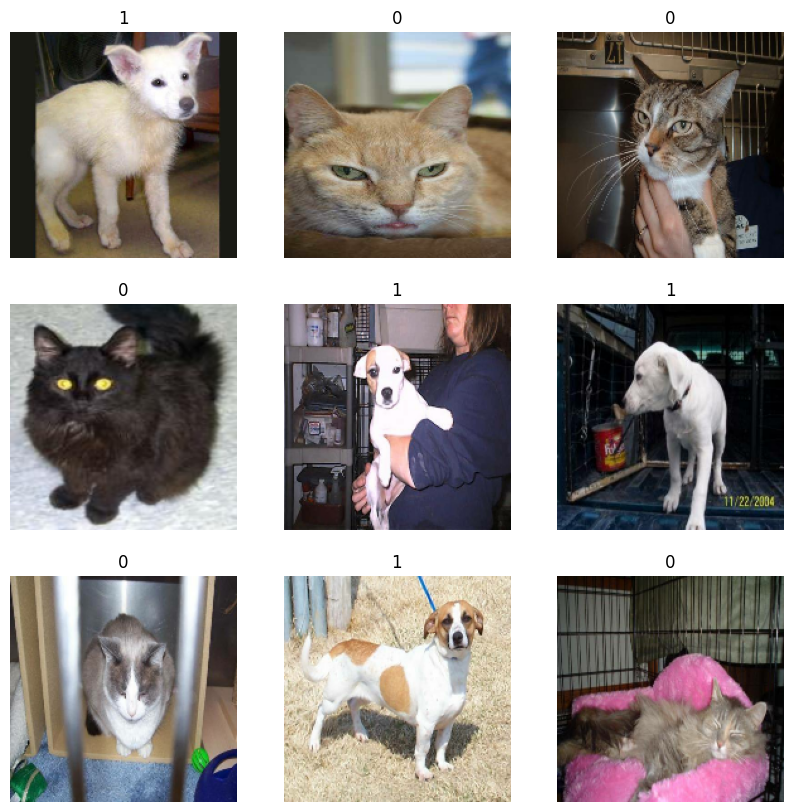

In [6]:
# Visualizing sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


### Defining the model

In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])


In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks
)


RuntimeError: input_dataset: Attempting to capture an EagerTensor without building a function.

In [ ]:
conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

# Freeze all layers except the last few
conv_base.trainable = False

# Build the model
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_vgg16 = keras.Model(inputs, outputs)

model_vgg16.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vgg16_fine_tuned.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history_vgg16 = model_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
63/63 [==============================] - 266s 4s/step - loss: 4.8624 - accuracy: 0.7260 - val_loss: 0.9475 - val_accuracy: 0.8970
Epoch 2/30
63/63 [==============================] - 276s 4s/step - loss: 2.1121 - accuracy: 0.8500 - val_loss: 0.6091 - val_accuracy: 0.9440
Epoch 3/30
63/63 [==============================] - 275s 4s/step - loss: 1.3038 - accuracy: 0.8930 - val_loss: 0.5002 - val_accuracy: 0.9620
Epoch 4/30
63/63 [==============================] - 281s 4s/step - loss: 1.0316 - accuracy: 0.9195 - val_loss: 0.4490 - val_accuracy: 0.9670
Epoch 5/30
63/63 [==============================] - 266s 4s/step - loss: 0.7218 - accuracy: 0.9355 - val_loss: 0.4195 - val_accuracy: 0.9680
Epoch 6/30
63/63 [==============================] - 273s 4s/step - loss: 0.5216 - accuracy: 0.9500 - val_loss: 0.3954 - val_accuracy: 0.9690
Epoch 7/30
63/63 [==============================] - 286s 5s/step - loss: 0.4405 - accuracy: 0.9515 - val_loss: 0.3790 - val_accuracy: 0.9690
Epoch 8/30
63

In [ ]:
best_model_custom = keras.models.load_model("./models/convnet_scratch.keras")
best_model_vgg16 = keras.models.load_model("./models/vgg16_fine_tuned.keras")


Evaluating Custom CNN
63/63 [==============================] - 12s 177ms/step - loss: 0.5754 - accuracy: 0.7115
Test Accuracy: 0.71
63/63 [==============================] - 10s 158ms/step
Confusion Matrix for Custom CNN


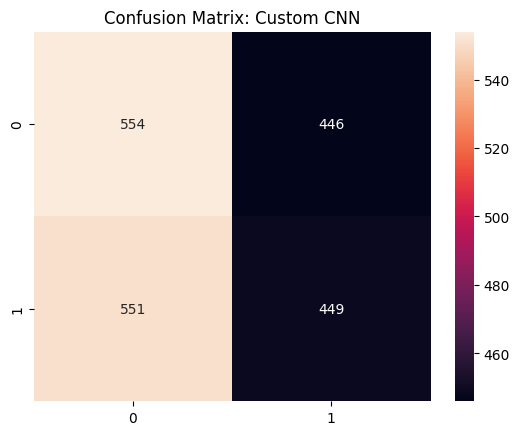

Classification Report for Custom CNN
              precision    recall  f1-score   support

           0       0.50      0.55      0.53      1000
           1       0.50      0.45      0.47      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



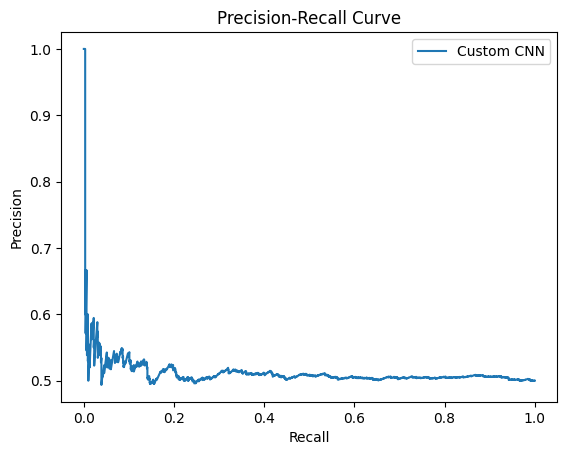

Evaluating VGG16
63/63 [==============================] - 183s 3s/step - loss: 0.2728 - accuracy: 0.9725
Test Accuracy: 0.97
63/63 [==============================] - 190s 3s/step
Confusion Matrix for VGG16


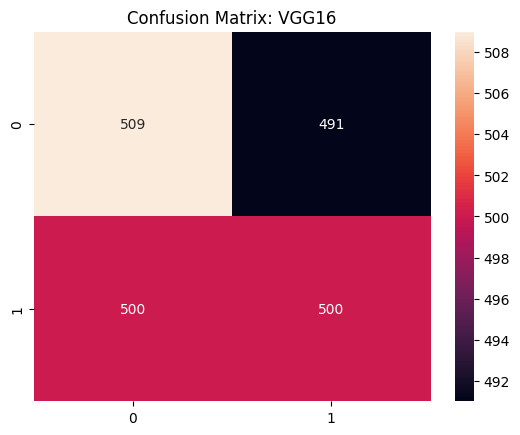

Classification Report for VGG16
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      1000
           1       0.50      0.50      0.50      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



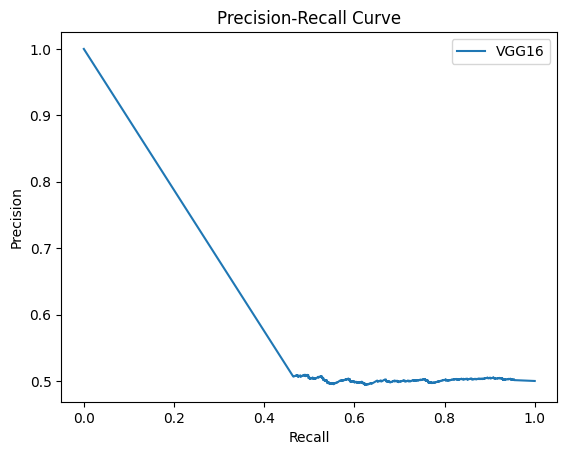

In [ ]:
# Evaluate models
for model, name in zip([best_model_custom, best_model_vgg16], ["Custom CNN", "VGG16"]):
    print(f"Evaluating {name}")
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_acc:.2f}")

    y_true = np.concatenate([y for _, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset).ravel()
    y_pred_classes = (y_pred > 0.5).astype(int)

    print(f"Confusion Matrix for {name}")
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    print(f"Classification Report for {name}")
    print(classification_report(y_true, y_pred_classes))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=name)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
